## A Note on the 8 page limit

I decided to try experiment with the 'literate programming' form-factor of having code embedded in a written document. Unfortunately this meant that it could not feasibly be kept to 8 pages without doing things that would ruin the clarity. Personally I think its a great way to write technical documents as it make it explict what is going on and encourages clean and concise programming while the code sections can also easily be ignored. 

# Inhibitory-Stabilised Network (ISN) and Paradoxical Inhibition

In [1]:
# Imports
using Plots, Measures

In [2]:
# Define our Network (can be ISN or SSN)
Base.@kwdef mutable struct Network
    γ   = 2.0  # (SSN only)
    β   = 1.0
    δt  = 1.0
    rₑs = [0.0]; rᵢs = [0.0];  
    uₑs = [1.0]; uᵢs = [1.0];  
    τₑ  = 10;  τᵢ  = 10
    Wᵢₑ = 1.8; Wₑᵢ = 1.8; Wᵢᵢ = 1.0; Wₑₑ = 1.5 
    ssn_flg = false
end

Network

## Biological Relevance

### Interpreting the terms of equations (1,2)

| Term       | Description                                                             |
|------------|-------------------------------------------------------------------------|
| E/e        | Excitatory (pool of neurons)                                            |
| I/i        | Inhibitory (pool of neurons)                                            |
| $r_e$      | Average Excitatory activity (in pool)                                   |
| $r_i$      | Average Inhibitory activity (in pool)                                   |
| $\beta (x)$ | Response function (proportional the the cells firing)                  |
| $W_{xy}$   | Strength of the interactions between neuron groups                      |
| $\tau _x$  | Time for cells to begin firing |
| $u_x$      | Average external input from other brain regions |

### Biological Limitations of ISN

There are a number of way our model is biologically unrealistic, generally being a simplified abstraction rather than a highly complex model. For example the neuron states are averaged across the whole pool which could be in a loss of potentially important information.

### Advantages of ISN over more Biologically Realistic Models

Possible advantages of Tsodyks et al,. ISN model over more biologically realistic models:

*Abstract > Specific*:
The strength of the model lies in its abstract nature; easier to scrutinize, more robust and can be applied across a broader rage of cases.

*Homomorphism > Isomorphism*: 
Its only the 'important' functionality that we want to map. Biological realism is not the goal, functional approximation is.

*Occams razor*: 
We want minimally simple models capable of explaining important phenomenon. Biologically realism will require massive amounts of redundant computation.

*Interpretability*: 
We want models that are easily interpretable to humans.

In conclusion Biology is massively complex at multiple levels of analysis (many of which will be beyond the scope of any specific investigation) and making progress in our understanding requires *abstraction* and *dimensionality reduction*.

## Simulate and Plot Net 1 ($u_E = 1$, $u_I = 1$, $N_t = 500$)

In [3]:
# Translating our models Update function to julia code 
function step!(n::Network, freeze_rᵢ_flg=false)
    
    # response function
    ϕ(x) = !(n.ssn_flg) ? (n.β*x) : (x > 0 ? n.β * x^n.γ : 0)
   
    # Euler Step
    ∂rₑ = (-n.rₑs[end] + ϕ(n.Wₑₑ*n.rₑs[end] - n.Wₑᵢ*n.rᵢs[end] + n.uₑs[end])) / n.τₑ
    ∂rᵢ = (-n.rᵢs[end] + ϕ(n.Wᵢₑ*n.rₑs[end] - n.Wᵢᵢ*n.rᵢs[end] + n.uᵢs[end])) / n.τᵢ
   
    # update
    push!(n.rₑs, n.rₑs[end] + n.δt*∂rₑ)
    push!(n.rᵢs, n.rᵢs[end] + n.δt*∂rᵢ)
    # for when uₓ is manually updated
    push!(n.uₑs, n.uₑs[end])
    push!(n.uᵢs, n.uᵢs[end])

    if (freeze_rᵢ_flg)
        n.rᵢs[end] = n.rᵢs[end-1]
    end
end

# number of steps simulated in a network
num_steps(n::Network) = length(n.rₑs)

num_steps (generic function with 1 method)

In [4]:
# Simple siulation of our network (no updates)
function simulate_net_simple!(n::Network, Nₜ, ss_flg=false, freeze_rᵢ_flg=false)
    
    for i=1:Nₜ
        step!(n, freeze_rᵢ_flg)  # <- update
        
        # break if in steady state (and ss flag)
        if ss_flg && i > 2 && steady_state(n.rₑs)       
            break
        end
    end 
    
    return n
end
# `steady_state` = 3 consecutive equal results
steady_state(arr) = (arr[end] == arr[end-1] == arr[end-2])


# Combine the most common steps into a Simulation function
function simulate_net!(n::Network, Nₜ, updates=Dict(), ss_flg=false, freeze_rᵢ_flg=false) 
    
    if isempty(updates)
        simulate_net_simple!(n,Nₜ)
        
    else
        simulate_net_simple!(n,Nₜ÷2,ss_flg)    
        update_net!(n, updates)
        simulate_net_simple!(n,(Nₜ÷2),ss_flg,freeze_rᵢ_flg)
    end
    
    return n 
end


# Update net parameters mid-simulation
function update_net!(n::Network, updates)
    if haskey(updates, "uₑ")
        n.uₑs[end] = get(updates,"uₑ", 0)
    end
    if haskey(updates, "uᵢ")
        n.uᵢs[end] = get(updates,"uᵢ", 0)
    end  
    if haskey(updates, "rₑ")
        n.rₑs[end] = get(updates,"rₑ", 0)
    end  
    if haskey(updates, "rᵢ")
        n.rᵢs[end] = get(updates,"rᵢ", 0)
    end
end 


# Simulates net and plots rₑ and rᵢ
function simulate_and_plot!(n::Network, Nₜ, title, updates=Dict(), ss_flg=false, freeze_rᵢ_flg=false) 
    
    simulate_net!(n,Nₜ,updates,ss_flg,freeze_rᵢ_flg) 
            
    return plot_simulation(1:num_steps(n),hcat(n.rₑs,n.rᵢs),title)
end

simulate_and_plot! (generic function with 4 methods)

In [5]:
# Plot rₑ and rᵢ over time
function plot_simulation(x, y, title)
    plot(x, y, 
        title=title, titlefont = font(12),
        xlabel="time (ms)", ylabel="Activity",
        label=["rₑ" "rᵢ"],
        size=(400,300)
    )
end

# Plot two simulations side by side
function plot_simulation_double(p₁, p₂)
    plot(p₁, p₂, 
        layout=(1,2), size=(800,300), 
        titlefont=font(12), 
        bottom_margin=5mm, left_margin=5mm, top_margin=5mm)
end

plot_simulation_double (generic function with 1 method)

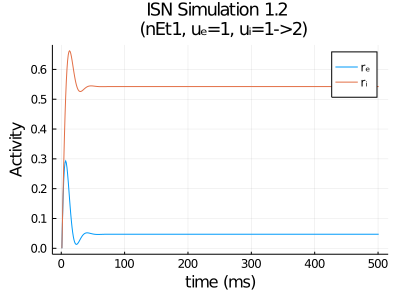

In [6]:
title = "ISN Simulation 1.2 \n (nEt1, uₑ=1, uᵢ=1->2)"
n     = Network(Wₑₑ=0.5)
Nₜ    = 500
simulate_and_plot!(n,Nₜ,title)

## Repeat, increasing $u_{I}$ to $2$ after 500 time steps

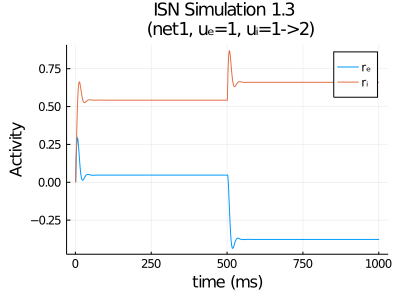

In [7]:
title = "ISN Simulation 1.3 \n (net1, uₑ=1, uᵢ=1->2)"
n     = Network(Wₑₑ=0.5)
Nₜ    = 1000
updt  = Dict("uᵢ" => 2)
simulate_and_plot!(n,Nₜ,title,updt)

$r_E$ and $r_I$ both spike initially. $r_i$ stays near this increased level until $u_I$ is increased while $r_E$ returns to near 0. After $u_I$ is increased $r_E$ and $r_I$ diverge with another net positive spike for $r_I$ and a large dip for $r_E$ taking it into the negative.

## Repeat 1.2 and 1.3 for Net 2 

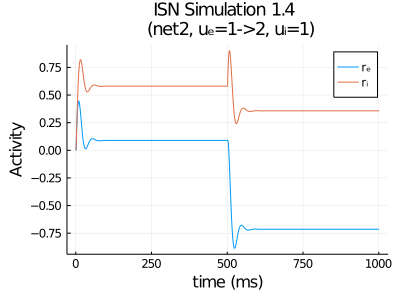

In [8]:
title = "ISN Simulation 1.4 \n (net2, uₑ=1->2, uᵢ=1)"
n     = Network()
Nₜ    = 1000
updt  = Dict("uᵢ" => 2)
simulate_and_plot!(n,Nₜ,title,updt)

The change in $r_1$ following increased $u_1$ in Network 2 is considered paradoxical because a state of reduced excitability is induced by a response of increased excitability ($r_i$).

## Simulate and Plot input to 'I' cells 

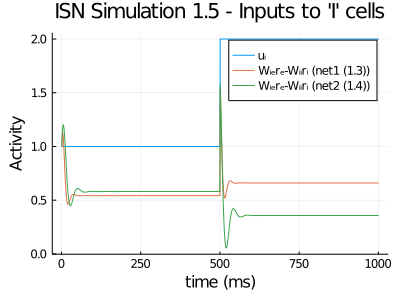

In [9]:
# -- 1.5. Simulate and Plot ISN input to 'I' cells --
n₁ = Network(Wₑₑ=0.5); n₂ = Network()
Nₜ   = 1000
updt = Dict("uᵢ" => 2)
simulate_net!(n₁,Nₜ,updt)  # Question 3
simulate_net!(n₂,Nₜ,updt)  # Question 4

Wterms(n)  = [ Wterm(n,i) for i in 1:num_steps(n) ]
Wterm(n,i) = (n.Wᵢₑ*n.rₑs[i]) - (n.Wᵢᵢ*n.rᵢs[i]) + n.uᵢs[i]

plot(1:num_steps(n), hcat(n₁.uᵢs, Wterms(n₁),Wterms(n₂)),
    title="ISN Simulation 1.5 - Inputs to 'I' cells",
    xlabel="time (ms)", ylabel="Activity",
    label=["uᵢ" "Wᵢₑrₑ-Wᵢᵢrᵢ (net1 (1.3))" "Wᵢₑrₑ-Wᵢᵢrᵢ (net2 (1.4))"],
    size=(400,300)
)

A paradoxical response of $r_I$ occurs in Network 2 but not Network 1 because the inputs to Network 2 experience paradoxical inhibition themselves.

## Increasing $u_E$

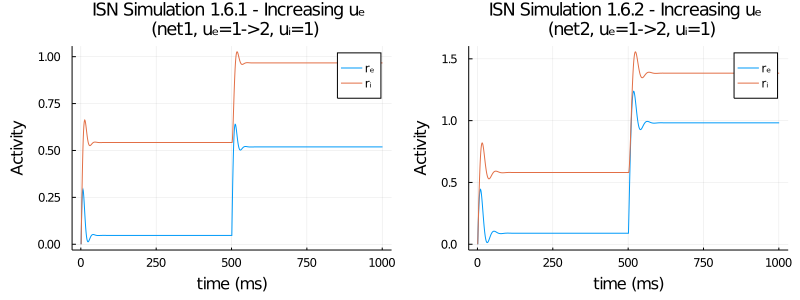

In [10]:
# -- 1.6. Simulate and Plot ISN (uₑ=1->2, uᵢ=1) --
n₁   = Network(Wₑₑ=0.5); n₂ = Network()
Nₜ   = 1000
updt = Dict("uₑ" => 2)

title₁ ="ISN Simulation 1.6.1 - Increasing uₑ \n (net1, uₑ=1->2, uᵢ=1)"
title₂ ="ISN Simulation 1.6.2 - Increasing uₑ \n (net2, uₑ=1->2, uᵢ=1)"
p₁ = simulate_and_plot!(n₁,Nₜ,title₁,updt)
p₂ = simulate_and_plot!(n₂,Nₜ,title₂,updt)

plot_simulation_double(p₁,p₂)

Both networks experience the increase in $u_E$ similarly with large spike in activity that plateaus off at a higher base level. The spike is particularly steep for $r_E$ in network 2. Neither experience paradoxical inhibition which suggests that this phenomenon is exclusively related to inhibitory input.

## 1.6 and freezing $r_I$

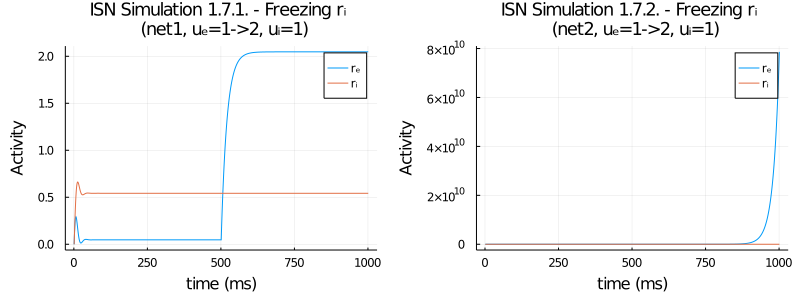

In [11]:
# -- 1.7. Simulate and Plot ISN (uₑ=1->2, uᵢ=1, rᵢ=freeze @ Nₜ(500)) --
n₁   = Network(Wₑₑ=0.5); n₂ = Network()
Nₜ   = 1000
updt = Dict("uₑ" => 2)
ss_flg, freeze_rᵢ_flg = false, true

title₁ = "ISN Simulation 1.7.1. - Freezing rᵢ \n (net1, uₑ=1->2, uᵢ=1)"
title₂ = "ISN Simulation 1.7.2. - Freezing rᵢ \n (net2, uₑ=1->2, uᵢ=1)"
p₁ = simulate_and_plot!(n₁,Nₜ,title₁,updt,ss_flg,freeze_rᵢ_flg)
p₂ = simulate_and_plot!(n₂,Nₜ,title₂,updt,ss_flg,freeze_rᵢ_flg)

plot_simulation_double(p₁,p₂)

After $u_E$ is increased, $r_E$ get a major spike in Network 1 (1.7.1) soon reaching a stable state (~600ms). In network 2 (1.7.2), the increase in $u_E$ leads to uncontrolled exponential growth.

## Comment on Inhibition 

The role of inhibition in dynamically stabilising network responses is related to preventing the exponential growth seen in 1.7.2. This can lead to paradoxical inhibition when the response outweights the initial spike.

## Advantages on Analytical approach

Some advantages of an *analytical approach* over a *simulation based approach* could be,

*Necessitates greater understanding*:
Simulations could theoretically be performed with very little understanding of the model or its relevance to practical applications (e.g. biological systems). This could lead to better generalisability.

I would also stress the advantages of the simulation based approach over an analytic approach (to the extent that they are competing rather than complementary). Arguably, for a dynamic system, an analytic approach is still somewhat a 'simulation', just that the simulation is internal to the human. Computational simulations are exceptionally more powerful human simulations and in my opinion this has been a first order driving force of scientific progress for the last ~50 years.

## Finding inhibitory-stabilisation

Look for highly connected clusters of inhibitory cells and see how they respond to activity spikes. Complexity of real systems might make it alot harder to locate te phenomenon that is being looked for and the abstract nature of the model might undermine its ability to make concrete predictions. 

# Supralinear Stabilised Network (SSN)

## Plot $\phi(x)$ against $x$ 

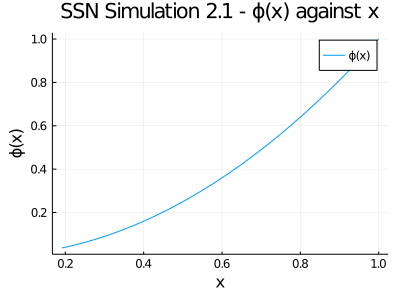

In [12]:
# -- 2.1. Simulate and Plot ϕ(x) against x --
n  = Network(ssn_flg=true,δt=0.1)
Nₜ = 1000
simulate_net!(n,Nₜ)

x(n,i) = n.Wₑₑ*n.rₑs[i] - n.Wₑᵢ*n.rᵢs[i] + n.uₑs[i]
xs(n)  = [x(n,i) for i in 1:num_steps(n)]

ϕ(n,x) = x > 0 ? n.β * x^n.γ : 0.0 
ϕs(n)  = [ϕ(n,x) for x in xs(n)]

plot(xs(n), ϕs(n),
    title="SSN Simulation 2.1 - ϕ(x) against x",
    xlabel="x", ylabel="ϕ(x)",
    label="ϕ(x)",
    size=(400,300)
)

This transfer function (exponential) could be deemed biologically implausible in that it does not provide efficient transfer with respect to in input size, and hence be resource intensive and break the biological principle of energy conservation. Additionally if left unbounded it could cause general instability in a network. 

## Simulate with $u_E = u_I = 1$.

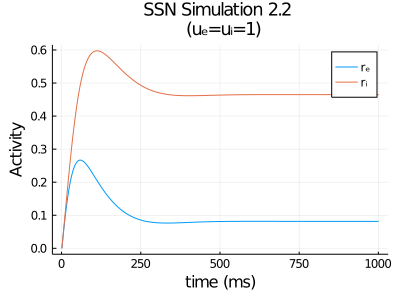

In [13]:
title = "SSN Simulation 2.2 \n (uₑ=uᵢ=1)"
n  = Network(ssn_flg=true,δt=0.1)
Nₜ = 1000
simulate_and_plot!(n,Nₜ,title)

## Simulate $u_E = u_I = c$

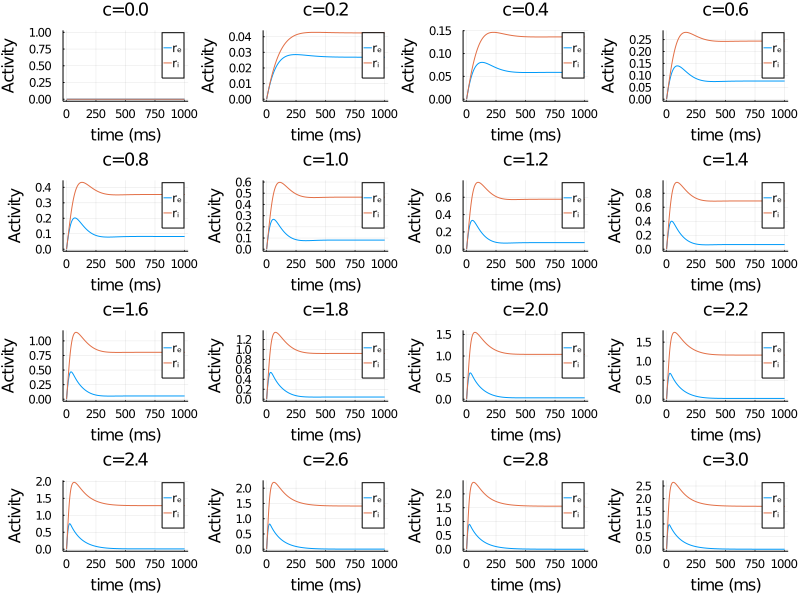

In [14]:
# -- 2.3 Simulate and Plot SSN  (0 <= c <= 3) --
Nₜ    = 1000
plots = []

# Simulate
for c=0:0.20:3
    n = Network(ssn_flg=true,δt=0.1,uₑs=[c],uᵢs=[c])
    push!(plots, simulate_and_plot!(n,Nₜ,"c="*string(c)))
end

plot(plots..., layout=(4,4), size=(800,600))

We observe that as $c$ (the external input from the rest of the brain) is increased both $r_E$ and $r_i$ experience more extreme spiking and dropping off. At low levels of $c$ the graphs look similar to a log function, increasing then gradually reaching a steady state.

## Contrast-dependence 

DID NOT ANSWER

## Simulate increasing $u_I$

In [15]:
# SSN Input classes
input1() = Network(ssn_flg=true,δt=0.1,uₑs=[0.1],uᵢs=[0.1])
input2() = Network(ssn_flg=true,δt=0.1,uₑs=[10.0], uᵢs=[3.0])

input2 (generic function with 1 method)

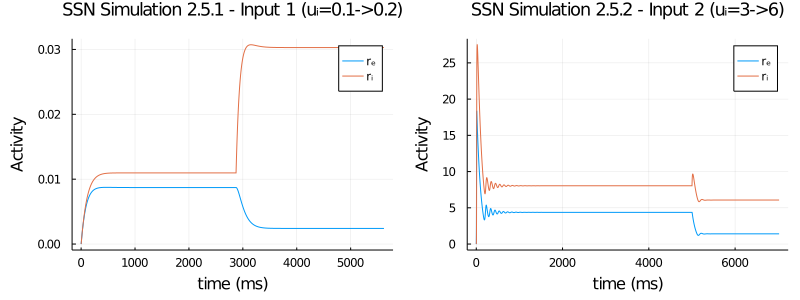

In [16]:
# -- 2.5. Simulate and Plot SNN (uᵢ++ @ steady_state) --
n₁ = input1(); n₂ = input2()

Nₜ = 10000  # large artificial upper bound
updt₁ = Dict("uᵢ" => 0.2); updt₂ = Dict("uᵢ" => 6)
ss_flg, freeze_rᵢ_flg = true, false

title₁ = "SSN Simulation 2.5.1 - Input 1 (uᵢ=0.1->0.2)"
title₂ = "SSN Simulation 2.5.2 - Input 2 (uᵢ=3->6)"
p₁ = simulate_and_plot!(n₁,Nₜ,title₁,updt₁,ss_flg,freeze_rᵢ_flg)
p₂ = simulate_and_plot!(n₂,Nₜ,title₂,updt₂,ss_flg,freeze_rᵢ_flg)

plot_simulation_double(p₁,p₂)


Paradoxical Inhibition occurs only in Input 2, after $u_i$ is raised to 6. This suggests suggest that paradoxical inhibition is linked to increased input activity from external regions.

##  Simulate with and without freezing $r_I$

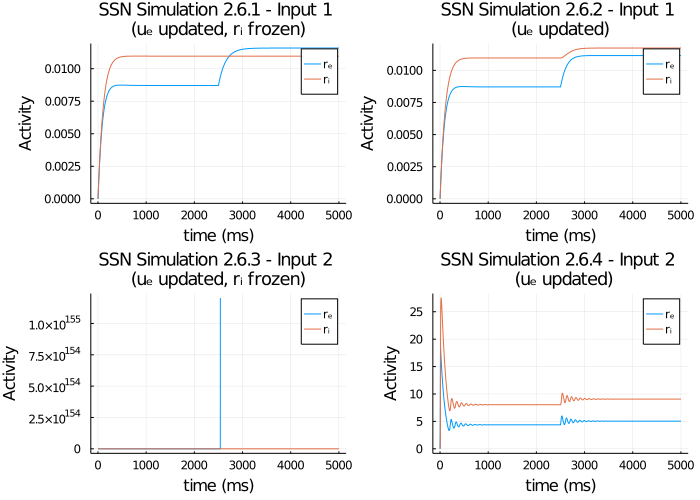

In [17]:
# -- 2.6. Simulate and Plot SNN (uₑ++ @ steady_state) --
n₁ = input1(); n₂ = input1(); n₃ = input2(); n₄ = input2();
Nₜ = 5000
updt₁₂ = Dict("uₑ" => 0.11); updt₃₄ = Dict("uₑ" => 11)

ss_flg, freeze_rᵢ_flg = true, false

title₁ = "SSN Simulation 2.6.1 - Input 1 \n(uₑ updated, rᵢ frozen)"
title₂ = "SSN Simulation 2.6.2 - Input 1 \n(uₑ updated)"
title₃ = "SSN Simulation 2.6.3 - Input 2 \n(uₑ updated, rᵢ frozen)"
title₄ = "SSN Simulation 2.6.4 - Input 2 \n (uₑ updated)"
p₁ = simulate_and_plot!(n₁,Nₜ,title₁,updt₁₂,true,true)
p₂ = simulate_and_plot!(n₂,Nₜ,title₂,updt₁₂,true,false)
p₃ = simulate_and_plot!(n₃,Nₜ,title₃,updt₃₄,true,true)
p₄ = simulate_and_plot!(n₄,Nₜ,title₄,updt₃₄,true,false)

plot(p₁,p₂,p₃,p₄,layout=(2,2), size=(700,500))


In 2.6.1 $r_E$ spikes when $r_I$ is frozen similarly to 2.6.2 when it is not. In 2.6.3 $r_E$ is unstable and tends to infinity very quickly and in 2.6.4 the network is stablised in an oscillating motion.  

## Commentary

In the SSN inhibitory stabilisation is important to keep the the network functional because when it is removed and the $u_X$ (external input) the network is unstable as in 2.6.3. I have plotted similar simulations with the linear model bellow. The effect as similar in some ways and different in others. For example in 2.6.1 the network is stablised whereas in 2.7.1 it is not. Additionally the oscillating patterns seen is 2.6.4 is not present in the ISN linear simulation. 

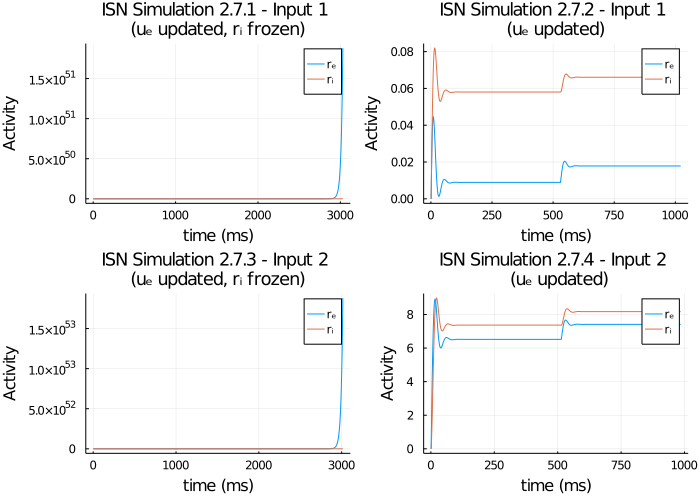

In [18]:
# -- 2.7. Simulate and Plot ISN (uₑ++ @ steady_state) --
input1() = Network(uₑs=[0.1],uᵢs=[0.1])
input2() = Network(uₑs=[10.0], uᵢs=[3.0])

n₁ = input1(); n₂ = input1(); n₃ = input2(); n₄ = input2();
Nₜ = 5000
updt₁₂ = Dict("uₑ" => 0.11); updt₃₄ = Dict("uₑ" => 11)

ss_flg, freeze_rᵢ_flg = true, false

title₁ = "ISN Simulation 2.7.1 - Input 1 \n(uₑ updated, rᵢ frozen)"
title₂ = "ISN Simulation 2.7.2 - Input 1 \n(uₑ updated)"
title₃ = "ISN Simulation 2.7.3 - Input 2 \n(uₑ updated, rᵢ frozen)"
title₄ = "ISN Simulation 2.7.4 - Input 2 \n (uₑ updated)"
p₁ = simulate_and_plot!(n₁,Nₜ,title₁,updt₁₂,true,true)
p₂ = simulate_and_plot!(n₂,Nₜ,title₂,updt₁₂,true,false)
p₃ = simulate_and_plot!(n₃,Nₜ,title₃,updt₃₄,true,true)
p₄ = simulate_and_plot!(n₄,Nₜ,title₄,updt₃₄,true,false)

plot(p₁,p₂,p₃,p₄,layout=(2,2), size=(700,500))